## Benchmarking on Lomonosov-2
- some benchmarking needed first
 
 Protocol files are copied from https://github.com/intbio/gmx_protocols/tree/master/amber into
Protocols folder.
If others are needed modify then in the folder.

In [1]:
#Libraries and main variables initialized
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd
import numpy as np
import urllib.request, json
import os
import re
import nglview as nv
from funcs import get_files_from_git

#Reloading funcs if changed
from importlib import reload 
import funcs,config
reload(funcs)
reload(config)


%matplotlib inline
from IPython.display import Markdown, display
from config import folder,descr,pname,scuser,ssh_host
display(Markdown(descr))
print("Folder set to: ",folder)
print("Project name: ",pname)
print("User set to:",scuser)
print("SSH host set to:",ssh_host)




# MD simulations of H3-H4, tails truncated
- AMBER14SB force field
- 50 mM NaCl
- box 2nm


Folder set to:  h3-h4_tm
Project name:  h3-h4_tm
User set to: shaytan_1609


In [4]:
%%bash
rm -rf MDProtocols

In [5]:
#Set protocols URL
prot_url="https://api.github.com/repos/intbio/gmx_protocols/contents/amber"

In [6]:
get_files_from_git(prot_url,'MDProtocols/')

## Bench runs 200 ps - prepare files

In [9]:
%%bash  
#--out out --err err
gmx grompp -f MDProtocols/6_equil.mdp -c GMX_run/6_equil.gro -p GMX_system/topol.top \
-o GMX_run/bench.tpr -v  -r GMX_run/6_equil.gro -n GMX_system/index.ndx -po GMX_run/mdout_bench.mdp


processing topology...
turning all bonds into constraints...
turning all bonds into constraints...
turning all bonds into constraints...
turning all bonds into constraints...
turning all bonds into constraints...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.836 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 0.801 nm, buffer size 0.001 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 96x96x96, spacing 0.106 0.106 0.106
This run will generate roughly 15 Mb of data


                      :-) GROMACS - gmx grompp, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

## We need to do some benchmarking on Lomonosov-2

bench.tpr is the starting one.
mpirun -np $(($SLURM_JOB_NUM_NODES * 2)) gmx_mpi mdrun -ntomp $OMP_NUM_THREADS -gputasks 00 -pme cpu -nb gpu -s bench -o bench1 -g bench1 -e bench1

In [29]:
%%bash
for i in `seq 1 20`; do
cp Run_scripts/lomo2_run_bench.sh GMX_run/lomo2_run_bench$i.sh
echo "mpirun -np \$((\$SLURM_JOB_NUM_NODES * 2)) gmx_mpi mdrun -ntomp \$OMP_NUM_THREADS -gputasks 00 -pme cpu -nb gpu -s bench -o bench$i -g bench$i -e bench$i">>GMX_run/lomo2_run_bench$i.sh 
done

In [30]:
%%bash -s "$folder" "$ssh_host" --err err --out out
#Copy to SC

rsync -r GMX_run $2:~/_scratch/$1/;

In [31]:
%%bash -s "$folder" "$ssh_host" --out out --err err
for i in `seq 1 8`; do
ssh $2 "module load slurm gromacs/2018-gcc; cd ~/_scratch/$1/GMX_run; \
sbatch -p compute -t 00:15:00 -N $i lomo2_run_bench$i.sh"
done

In [ ]:
print(err)

In [32]:
#get job id
print(out)
job_ide=re.findall(r'\d+', out)
job_N={(i+1):job_ide[i] for i in range(0,8)}
print(job_N)

Submitted batch job 869533
Submitted batch job 869534
Submitted batch job 869535
Submitted batch job 869536
Submitted batch job 869537
Submitted batch job 869538
Submitted batch job 869539
Submitted batch job 869540

{1: '869533', 2: '869534', 3: '869535', 4: '869536', 5: '869537', 6: '869538', 7: '869539', 8: '869540'}


In [142]:
%%bash -s   "$job_ide"  "$ssh_host"  --err err
# check job status
ssh $2 "module load slurm gromacs/2018-gcc; squeue -u shaytan_1609 " || echo "No job in queue"

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            869585   compute  jobname shaytan_ PD       0:00     17 (Resources)
            869586   compute  jobname shaytan_ PD       0:00     18 (Resources)
            869587   compute  jobname shaytan_ PD       0:00     19 (Resources)
            869588   compute  jobname shaytan_ PD       0:00     20 (Resources)
            869591   compute  jobname shaytan_ PD       0:00     16 (Resources)


In [ ]:
%%bash -s "$folder" "$ssh_host"  --out out --err err
for i in `seq 9 16`; do
ssh $2 "module load slurm gromacs/2018-gcc; cd ~/_scratch/$1/GMX_run; \
sbatch -p test -t 00:15:00 -N $i lomo2_run_bench$i.sh"
done

In [ ]:
print(err)

In [97]:
#get job id
print(out)
job_ide=re.findall(r'\d+', out)
job_N.update({(i+9):job_ide[i] for i in range(0,8)})
print(job_N)

Submitted batch job 869562
Submitted batch job 869563
Submitted batch job 869564
Submitted batch job 869565
Submitted batch job 869566
Submitted batch job 869567
Submitted batch job 869568
Submitted batch job 869569

{1: '869558', 2: '869534', 3: '869535', 4: '869536', 5: '869537', 6: '869538', 7: '869539', 8: '869540', 9: '869562', 10: '869563', 11: '869564', 12: '869565', 13: '869566', 14: '869567', 15: '869568', 16: '869569'}


In [138]:
%%bash -s "$folder" "$ssh_host" --out out --err err
for i in `seq 17 20`; do
ssh $2 "module load slurm gromacs/2018-gcc; cd ~/_scratch/$1/GMX_run; \
sbatch -p compute -t 00:15:00 -N $i lomo2_run_bench$i.sh"
done

In [ ]:
print(err)

In [139]:
#get job id
print(out)
job_ide=re.findall(r'\d+', out)
job_N.update({(i+17):job_ide[i] for i in range(0,4)})
print(job_N)

Submitted batch job 869585
Submitted batch job 869586
Submitted batch job 869587
Submitted batch job 869588

{1: '869558', 2: '869534', 3: '869535', 4: '869536', 5: '869537', 6: '869538', 7: '869539', 8: '869540', 9: '869562', 10: '869563', 11: '869564', 12: '869565', 13: '869566', 14: '869567', 15: '869568', 16: '869569', 17: '869585', 18: '869586', 19: '869587', 20: '869588'}


In [ ]:
%%bash -s "$folder" "$ssh_host" --err err 
#Purge # files

ssh $2 "rm -f ~/_scratch/$1/GMX_run/\#*; ls ~/_scratch/$1/GMX_run/"

In [143]:
%%bash -s "$folder" "$ssh_host" --err err --out out
#Get back data

scp $2:~/_scratch/$1/GMX_run/egmx* GMX_run/ ;

#### Analyze what we get

In [149]:
job_N.update({1:'869558'})
job_N.update({16:'869602'}) #speed 142 ns per day
speed=[]
nodes=[1,2,3,4,5,6,8,9,10,12,14,15,18,20]
for k in nodes:
    with open('GMX_run/egmx.%s'%job_N[k]) as f:
        data=f.read()
        ns_per_day=re.findall(r'Performance:\s+(\d+)\.', data)[0]
        print(k, job_N[k] ,ns_per_day)
        speed.append(float(ns_per_day))

1 869558 17
2 869534 70
3 869535 84
4 869536 93
5 869537 97
6 869538 105
8 869540 118
9 869562 122
10 869563 129
12 869565 132
14 869567 140
15 869568 141
18 869586 148
20 869588 148


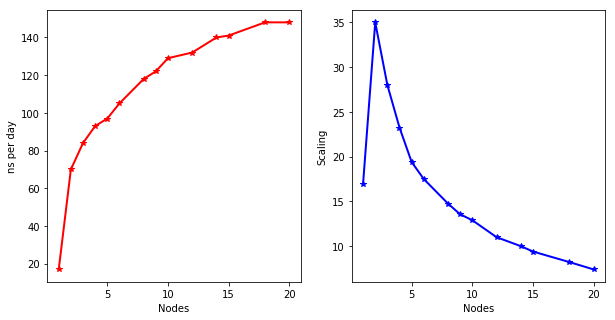

In [150]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
ax = plt.subplot(121)
ax.plot(nodes, speed, 'r*-', lw=2, label=r"ns per day")
ax.set_xlabel("Nodes")
ax.set_ylabel("ns per day")
ax2 = plt.subplot(122)
ax2.plot(nodes, [speed[i]/nodes[i] for i in range(len(nodes))], 'b*-', lw=2, label=r"ns per day")
ax2.set_xlabel("Nodes")
ax2.set_ylabel("Scaling")
plt.draw()